In [19]:
!pip install sortedcontainers pyGMs

In [20]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from src.hmm import *
from src.utils import *

# load data

In [21]:
# this code is borrowed from https://sli.ics.uci.edu/extras/cs179/old/Demo%20-%20Ising%20Rainfall.html
BASE_PATH = "data/"

# rainfall data
data = np.loadtxt(BASE_PATH  + 'ghcnd_india_rain.txt', delimiter=',')

# date and station info
date = np.loadtxt(BASE_PATH  + 'ghcnd_india_date.txt')
with open(BASE_PATH  + 'ghcnd_india_stations.txt') as fh:
    txt = [line for line in fh.readlines() if not line.startswith('#')]

# latutude / longtitude
id = [None]*len(txt)
lat = np.zeros(len(txt))
lon = np.zeros(len(txt))
for i, line in enumerate(txt):
    id[i], lat[i], lon[i], _ = tuple(line[:37].split())

# filtering latitude /longtitude
keep = ((lon > 65) & (lon < 95) & (lat > 5) & (lat < 36))
data = data[:, keep]
lat, lon = lat[keep], lon[keep]

# convert to discrete binary rainfall labels 
# 1 if rain amount more than 5mm. 0 otherwise
labels = 1 * (data > 5)

In [22]:
print("shape: ", labels.shape) 
print("# days:     ", labels.shape[0]) 
print("# stations: ", labels.shape[1]) 

rainy_percent = 100 * (labels.sum() / labels.size)
print(f"Percentage of rainy days: {rainy_percent:.2f}%")

shape:  (3652, 53)
# days:      3652
# stations:  53
Percentage of rainy days: 16.04%


In [8]:
col_names = [f"{i}_({lat[i]:.2f},{lon[i]:.2f})" for i in range(len(lat))]
df_labels = pd.DataFrame(labels, columns=col_names)
df_labels

,"0_(20.90,70.37)","1_(14.45,79.98)","2_(15.85,74.62)","3_(30.33,76.47)","4_(21.52,86.93)","5_(20.85,88.25)","6_(21.22,81.67)","7_(25.15,75.85)","8_(18.53,73.85)","9_(15.42,75.63)",...,"43_(11.25,75.78)","44_(16.20,81.15)","45_(26.82,75.80)","46_(14.58,77.63)","47_(8.48,76.95)","48_(20.25,85.83)","49_(22.65,88.45)","50_(16.95,82.23)","51_(26.10,91.58)","52_(23.20,79.95)"
0,0,1,0,0,1,0,0,0,0,0,...,1,1,0,0,1,0,1,1,0,1
1,0,1,0,0,1,0,1,0,0,0,...,1,1,0,0,1,1,1,1,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3648,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3649,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3650,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# weather stations

/Users/nedamohseni/Desktop/CS 179/spatio-temporal/src/utils.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x,y,'k-',color=(.4,.4,.4));


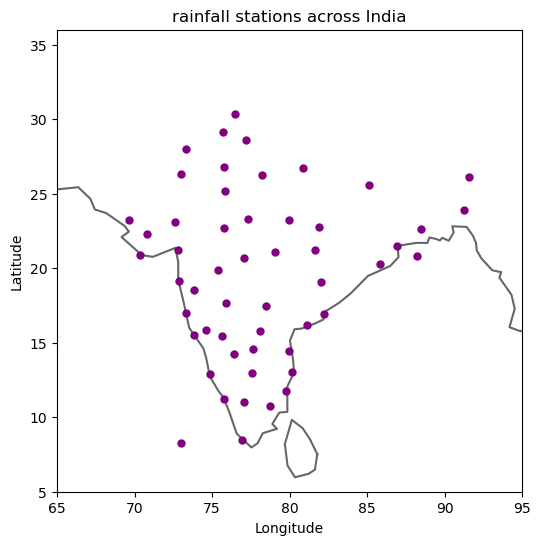

In [9]:
plt.figure(figsize=(6,6));
draw_map();
plt.plot(lon, lat, '.', color='purple', ms=10)

# Actual Rainfall Amounts

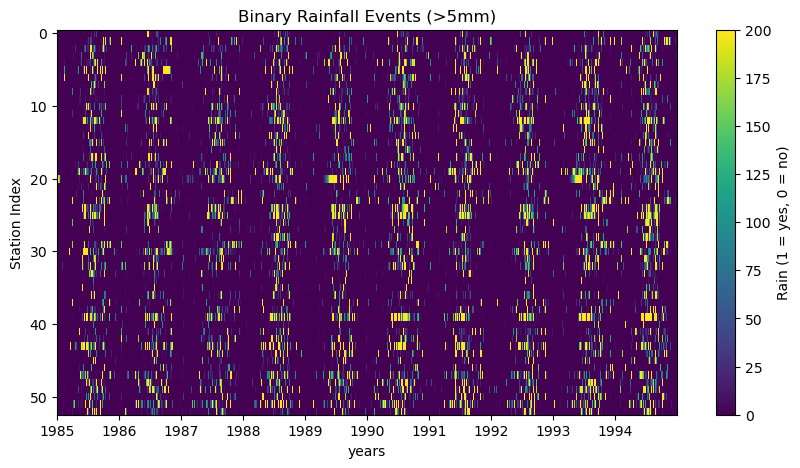

In [7]:
plt.figure(figsize=(10, 5))
plt.imshow(data.T, aspect='auto', interpolation='none', cmap='viridis', vmin=0, vmax=200)
new_year = (date[:,1]+date[:,2])==2;
plt.xticks(np.where(new_year)[0], labels=[str(int(y)) for y in date[new_year,0]]);
plt.xlabel("years")
plt.ylabel("Station Index")
plt.title("Binary Rainfall Events (>5mm)")
plt.colorbar(label="Rain (1 = yes, 0 = no)")
plt.show()

Text(0.5, 1.0, 'Binary Rainfall Events (>5mm)')

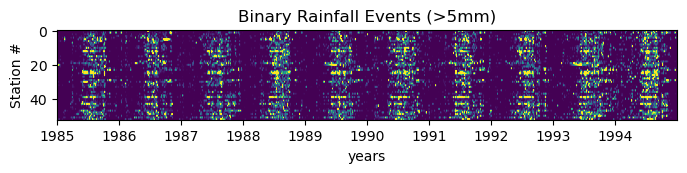

In [8]:
plt.figure(figsize=(8,5));
plt.imshow(data.T,aspect=10, cmap='viridis',  vmin=0, vmax=200);
new_year = (date[:,1]+date[:,2])==2;
plt.xticks(np.where(new_year)[0], labels=[str(int(y)) for y in date[new_year,0]]);
plt.xlabel("years")
plt.ylabel("Station #")
plt.title("Binary Rainfall Events (>5mm)")

# Model (HMM+Chow-Liu)

In [23]:
np.random.seed(12)

n =  3 # num latent state(K)
L =  len(labels)

# Transition Matrix (initialization)
T = np.eye(n) * 0.90 + 0.1   

# for initialization, each state’s emission is fit to a random 1000 day subset
emitters = [emitChowLiu(labels[np.random.choice(L, size=1000, replace=False)], 0.0) for _ in range(n)]
hmm_model = HMM(T, emitters)

# STRONG PRIOIR enforcing temporal consistency
hmm_model.T_prior = np.eye(n) * 50000.

for it in range(100):
    pll = hmm_model.EM(labels)
    if it < 10:
      print(f"iter {it}: {pll}")
    elif it % 10 == 0:
        print(f"iter {it}: {pll}")

print("\nmean PLL (per day): ", pll / len(labels))

iter 0: -64546.28777551472
iter 1: -64145.12179470757
iter 2: -61656.647876344134
iter 3: -60624.81361838206
iter 4: -60204.32760142686
iter 5: -59965.373283100875
iter 6: -59509.443528560136
iter 7: -59123.02045977085
iter 8: -58864.671384826914
iter 9: -58736.98919966611
iter 10: -58672.39182957121
iter 20: -58351.652574662025
iter 30: -58080.80468440755
iter 40: -58022.07898595088
iter 50: -58021.56784215988
iter 60: -58021.561250932704
iter 70: -58021.56123415983
iter 80: -58021.56123943378
iter 90: -58021.561239886374

mean PLL (per day):  -15.887612606768085


# Edges

In [11]:
for i in range(n):
    ising_cl = hmm_model.E[i].model  #ising model
    edges = [(int(f.vars[0]), int(f.vars[1])) for f in ising_cl.factors if len(f.vars) == 2]
    print(f"Edges for latent state Z = {i}, ", edges[:])

Edges for latent state Z = 0,  [(0, 28), (1, 29), (1, 50), (1, 51), (2, 11), (3, 33), (4, 48), (5, 48), (6, 32), (7, 31), (8, 14), (8, 25), (9, 11), (9, 32), (10, 42), (11, 25), (12, 25), (12, 39), (13, 14), (15, 17), (15, 52), (16, 28), (17, 21), (17, 33), (18, 41), (19, 49), (19, 51), (20, 51), (22, 23), (23, 29), (23, 37), (24, 25), (24, 28), (24, 36), (26, 35), (27, 33), (30, 47), (31, 36), (33, 35), (33, 36), (33, 45), (34, 51), (35, 40), (38, 44), (39, 43), (39, 47), (41, 46), (42, 50), (43, 44), (44, 46), (44, 50), (48, 49)]
Edges for latent state Z = 1,  [(0, 24), (0, 28), (1, 44), (2, 8), (2, 41), (3, 33), (4, 48), (4, 49), (5, 19), (6, 52), (7, 21), (7, 31), (7, 45), (8, 22), (8, 24), (9, 41), (10, 20), (11, 14), (11, 38), (12, 25), (12, 39), (12, 43), (13, 14), (13, 36), (15, 17), (15, 51), (16, 26), (16, 34), (17, 33), (18, 46), (19, 51), (20, 36), (22, 23), (22, 37), (23, 29), (24, 25), (24, 26), (26, 35), (26, 36), (27, 33), (30, 47), (31, 32), (31, 36), (31, 49), (31, 52

In [12]:
print("transition matrix: ")
print(hmm_model.T)

print("\nemission model")
print(hmm_model.E[0].model) # ising model for state 0 
print(hmm_model.E[1].model) # ising model for state 1
print(hmm_model.E[2].model) # ising model for state 2 

transition matrix: 
[[9.99037054e-001 3.86918804e-004 5.76026769e-004]
 [3.85933727e-004 9.99614066e-001 2.92362087e-118]
 [5.51338665e-004 5.47884823e-115 9.99448661e-001]]

emission model
Ising model: 53 vars, 104 factors
Ising model: 53 vars, 104 factors
Ising model: 53 vars, 104 factors


# posterior probs

(3652, 3)


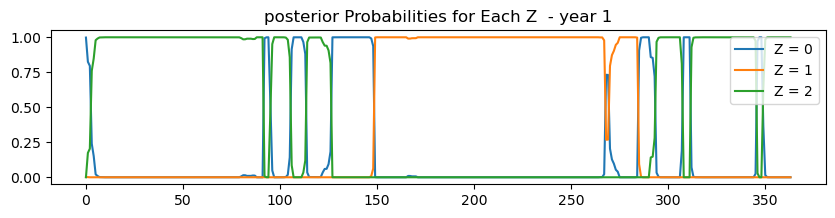

In [24]:
ll,alph,beta,Z_probs,obs= hmm_model.forward_backward(labels)
Z_seq = np.argmax(Z_probs, axis=1)

plt.figure(figsize = (10,2))
print(Z_probs.shape)
for k in range(Z_probs.shape[1]):
    plt.plot(Z_probs[1:365, k], label=f"Z = {k}") #first year only
plt.title("posterior Probabilities for Each Z  - year 1")
plt.legend(loc='upper right')
plt.show()

# latent States Over 10 Years

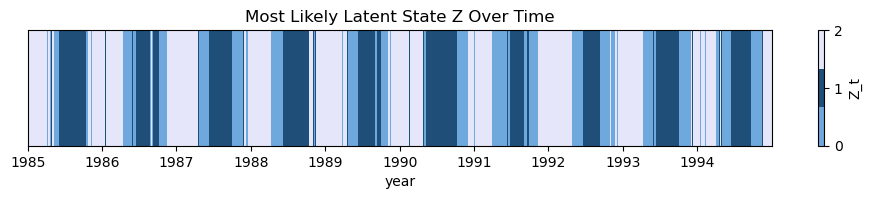

In [ ]:
cmap = ListedColormap(['#6fa8dc', '#1f4e79' , 'lavender'])
plt.figure(figsize=(12, 1.5))
plt.imshow(Z_seq.reshape(1, -1), aspect='auto', cmap=cmap)
new_year = (date[:,1]+date[:,2])==2;
plt.xticks(np.where(new_year)[0], labels=[str(int(y)) for y in date[new_year,0]]);
plt.yticks([])
plt.xlabel("year")
plt.title("Most Likely Latent State Z Over Time")
plt.colorbar(ticks=[0, 1, 2], label='Z_t')
plt.show()

# latent states divided by years

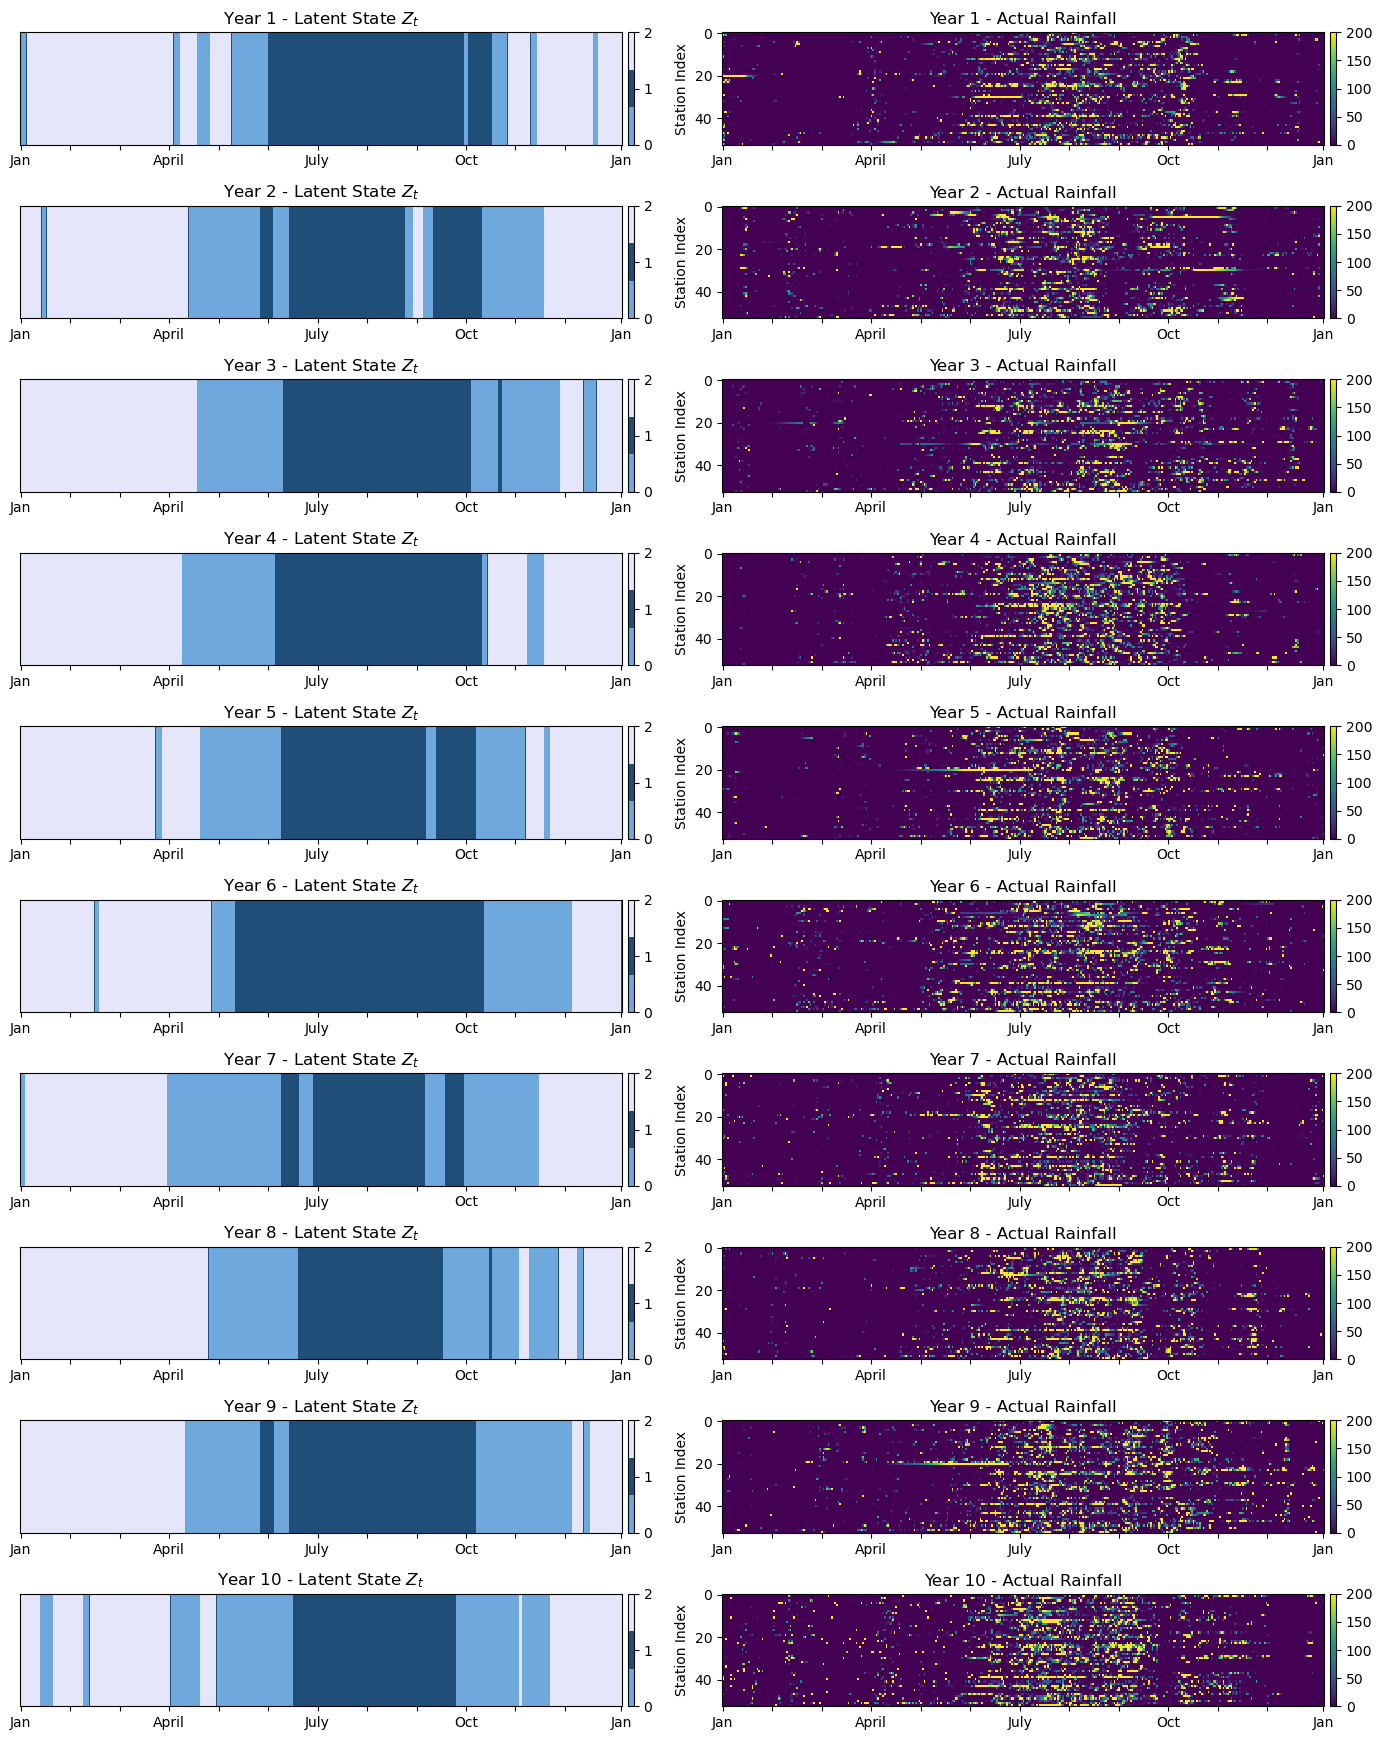

In [14]:
cmap_z = ListedColormap(['#6fa8dc', '#1f4e79' , 'lavender'])
years = 10

fig, axes = plt.subplots(nrows=years, ncols=2, figsize=(14, 1.75 * years))
for i in range(years):
    start = i * 365
    end = start + 365

    # latent states subplot
    ax_z = axes[i, 0]
    Z_year = Z_seq[start:end]
    im_z = ax_z.imshow(Z_year.reshape(1, -1), aspect='auto', cmap=cmap_z)
    ax_z.set_yticks([])
    ax_z.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 364])
    ax_z.set_xticklabels(['Jan', ' ' , ' ',  'April', ' ', ' ', 'July',' ', ' ' ,'Oct',' ', ' ', 'Jan'])
    ax_z.set_title(f"Year {i + 1} - Latent State $Z_t$")
    fig.colorbar(im_z, ax=ax_z, orientation='vertical', fraction=0.05, pad=0.01, ticks=[0, 1, 2])

    # actuall rainfall subplot
    ax_rain = axes[i, 1]
    data_year = data[start:end, :]
    im_rain = ax_rain.imshow(data_year.T, aspect='auto', interpolation='none', cmap='viridis', vmin=0, vmax=200)
    ax_rain.set_ylabel("Station Index")
    ax_rain.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 364])
    ax_rain.set_xticklabels(['Jan', ' ' , ' ',  'April', ' ', ' ', 'July',' ', ' ' ,'Oct',' ', ' ', 'Jan'])
    ax_rain.set_title(f"Year {i + 1} - Actual Rainfall")
    fig.colorbar(im_rain, ax=ax_rain, orientation='vertical', fraction=0.05, pad=0.01)

plt.tight_layout()
plt.show()

# Avg rainfall Frequency per station

num days assigned to z =  0 :  1008
num days assigned to z =  1 :  1150
num days assigned to z =  2 :  1494


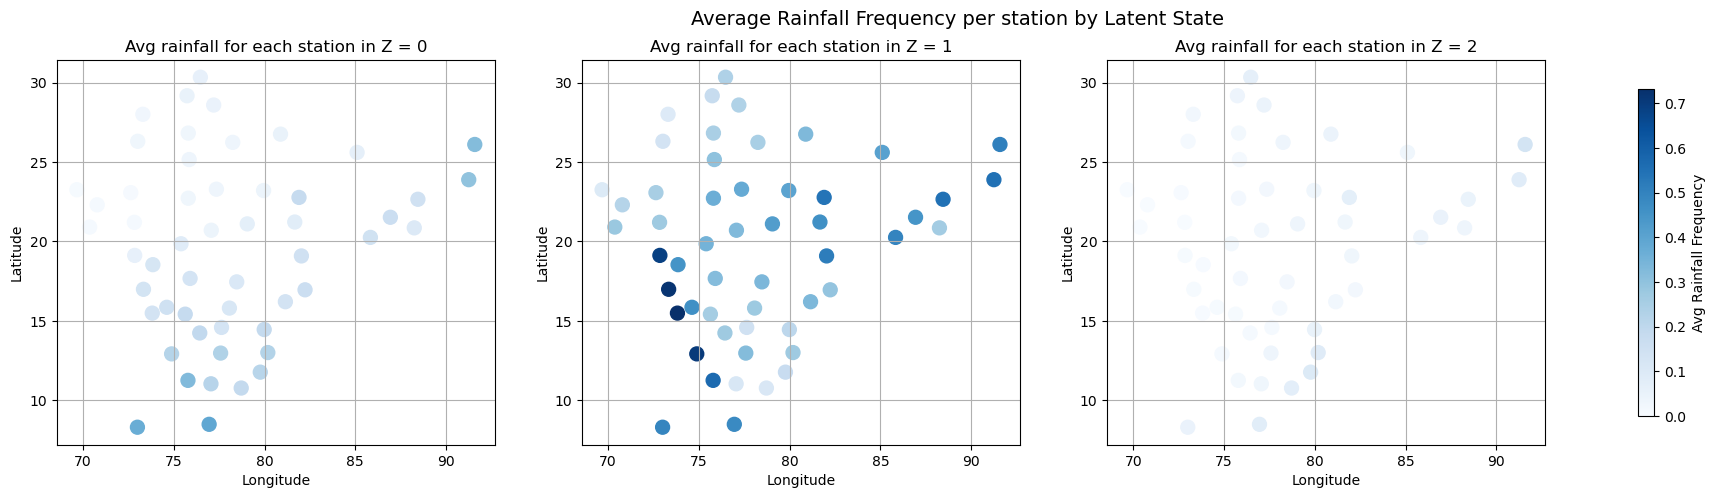

In [5]:
ll,alph,beta,Z_probs,obs= hmm_model.forward_backward(labels)
Z_seq = np.argmax(Z_probs, axis=1)

#compute all avg_rain and find global max (min is 0)
all_avg_rain = []
for k in range(n):
    days_k = np.where(Z_seq == k)[0]
    print("num days assigned to z = ", k , ": " , len(days_k))
    avg_rain = labels[days_k].mean(axis=0) #mean of each col (station)
    all_avg_rain.append(avg_rain)
global_max = np.max(all_avg_rain)

fig, axes = plt.subplots(1, n, figsize=(24, 5))
for idx, (k, avg_rain) in enumerate(zip(range(n), all_avg_rain)):
    ax = axes[idx]
    sc = ax.scatter(lon, lat, c=avg_rain, cmap='Blues', s=100, vmin=0, vmax=global_max) #normalized
    ax.set_title(f"Avg rainfall for each station in Z = {k}")
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.grid(True)

# one common colorbar across all plots
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=global_max))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label('Avg Rainfall Frequency')
fig.suptitle("Average Rainfall Frequency per station by Latent State", fontsize=14)
plt.show()

# single Chow Liu Tree on all data

Pseudo-likelihood:  [-32.89868402 -22.27378974 -13.42095294 ...  -6.34843132  -3.67821868
  -3.67821868]
(3652,)
mean Pseudo-likelihood(per day):  -18.590046690467744


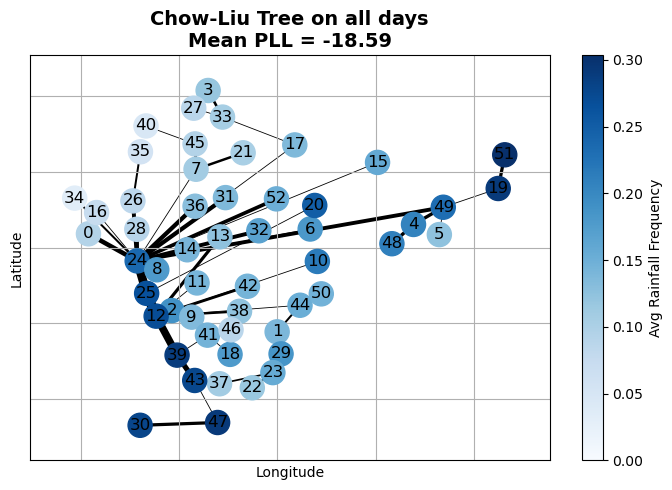

In [ ]:
# A SINGLE CHOW LIU FOR ALL DATA
ising_cl = gm.ising.Ising()
my_fit_chowliu(ising_cl, labels.T, penalty=0)

# Avg rainfall freq for each station across all days
avg_rain = labels.mean(axis=0)

# mean pll(per day)
pll_mean = ising_cl.pseudolikelihood(labels).mean()

fig, ax = plt.subplots(figsize=(7, 5))
draw_chowLiu_tree(ising_cl=ising_cl, lat=lat, lon=lon, rain_vals=avg_rain, ax=ax, vmin=0, vmax=np.max(avg_rain)) 
ax.set_title(f"Chow-Liu Tree on all days\nMean PLL = {pll_mean:.2f}", fontsize=14, fontweight='bold', loc='center')
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=np.max(avg_rain)))
sm.set_array([])
plt.colorbar(sm, ax=ax, label="Avg Rainfall Frequency")
plt.tight_layout()

print("Pseudo-likelihood: ",ising_cl.pseudolikelihood(labels)) # pll for each day 
print(ising_cl.pseudolikelihood(labels).shape)
print("mean Pseudo-likelihood(per day): ",ising_cl.pseudolikelihood(labels).mean()) #mean pll

# Chow-Liu Tree per Latent State

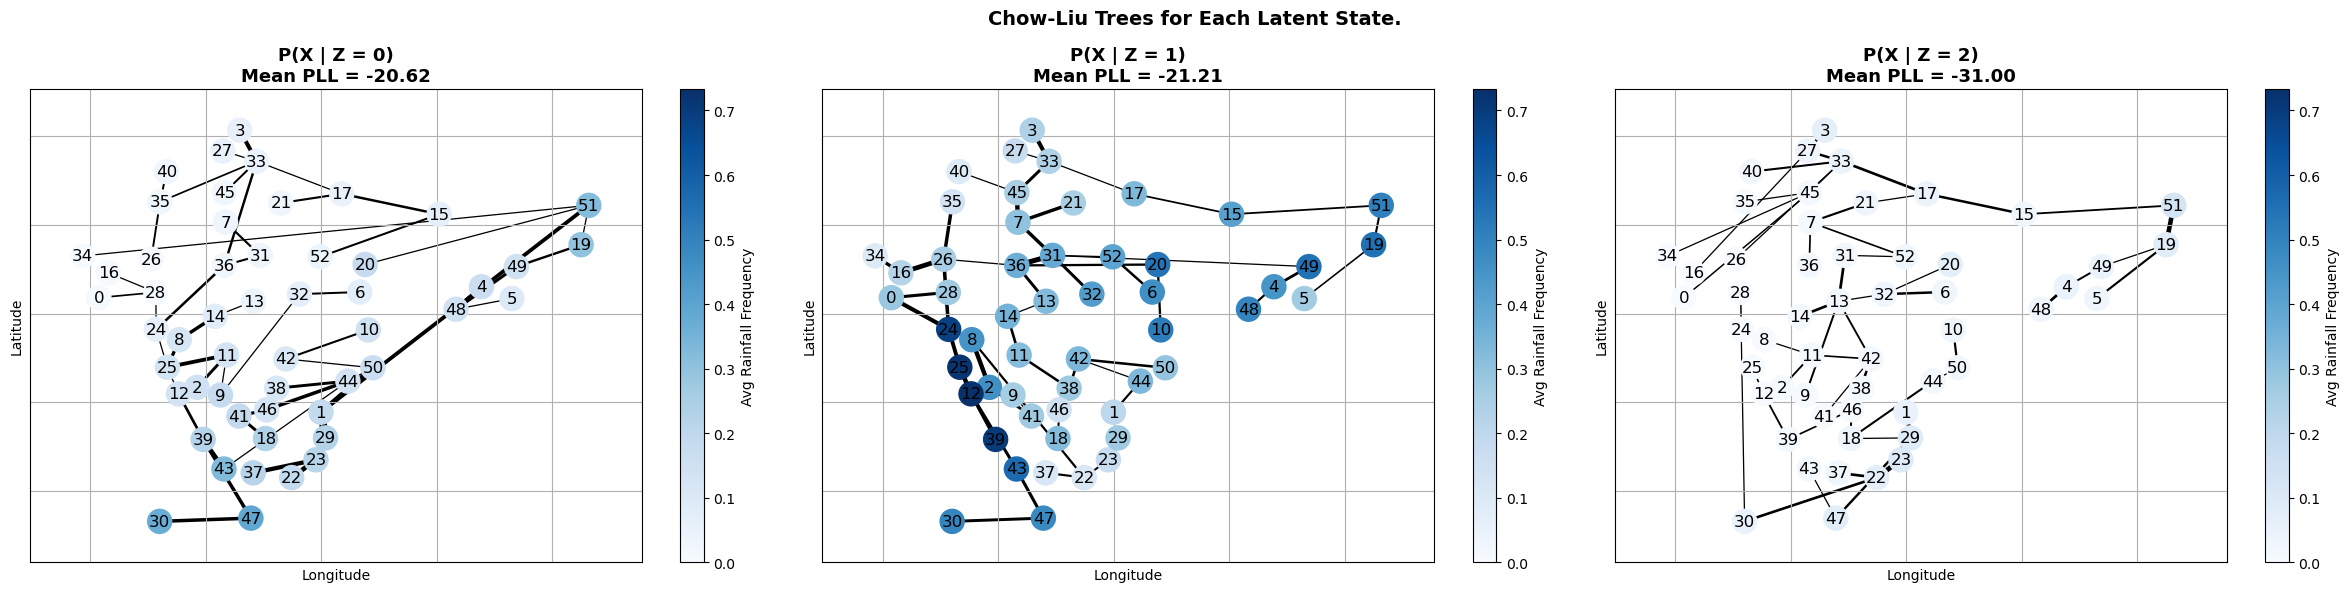

In [ ]:
# compute all avg_rain and to find global max for normalization (node colors)
avg_rains = []
for k in range(n):
    days_k = np.where(Z_seq == k)[0]
    avg_rain = labels[days_k].mean(axis=0)
    avg_rains.append(avg_rain)
global_max = np.max(avg_rains) # max rainfall freq 

# find global MI range across all states for normalization (edge colors)
all_mis = []
for k in range(n):
    mi_edges = getattr(hmm_model.E[k].model, "mutual_info_edges", [])
    all_mis.extend([mi for _, _, mi in mi_edges])
global_min_mi = min(all_mis)   #min MI 
global_max_mi = max(all_mis)   #MAX MI
  
fig, axes = plt.subplots(1, n, figsize=(24, 6))
for k in range(n):
    ax = axes[k]
    avg_rain = avg_rains[k]
    pseudo_ll = hmm_model.E[k].model.pseudolikelihood(labels).mean()

    draw_chowLiu_tree(ising_cl=hmm_model.E[k].model, lat=lat,lon=lon, rain_vals=avg_rain,ax=ax, 
                         vmin = 0, vmax = global_max,
                         global_min_mi=global_min_mi, global_max_mi=global_max_mi)

    ax.set_title(f"P(X | Z = {k})\nMean PLL = {pseudo_ll:.2f}", fontsize=13, fontweight='bold')

    #color scale to global range for consistency
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=global_max))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Avg Rainfall Frequency")

fig.suptitle("Chow-Liu Trees for Each Latent State", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Adding BIC Penalty to Chow-Liu Trees (penalty = 0.015)

In [7]:
np.random.seed(12)

n =  3
L =  len(labels)

T = np.eye(n) * 0.90 + 0.1
emitters = [emitChowLiu(labels[np.random.choice(L, size=1000, replace=False)], 0.015) for _ in range(n)]
hmm_model2 = HMM(T, emitters )
hmm_model2.T_prior = np.eye(n) * 50000.

for it in range(100):
    ll = hmm_model2.EM(labels)
    if it % 10 == 0:
        print(f"iter {it}: {ll}")
print("\nmean PLL: ", ll / len(labels))

iter 0: -64590.22180371916
iter 10: -59512.78805595789
iter 20: -59157.08345973334
iter 30: -59151.882362766024
iter 40: -59151.88022718654
iter 50: -59151.880232446885
iter 60: -59151.88023268177
iter 70: -59151.88023268631
iter 80: -59151.880232686344
iter 90: -59151.88023268632

mean PLL:  -16.197119450352226


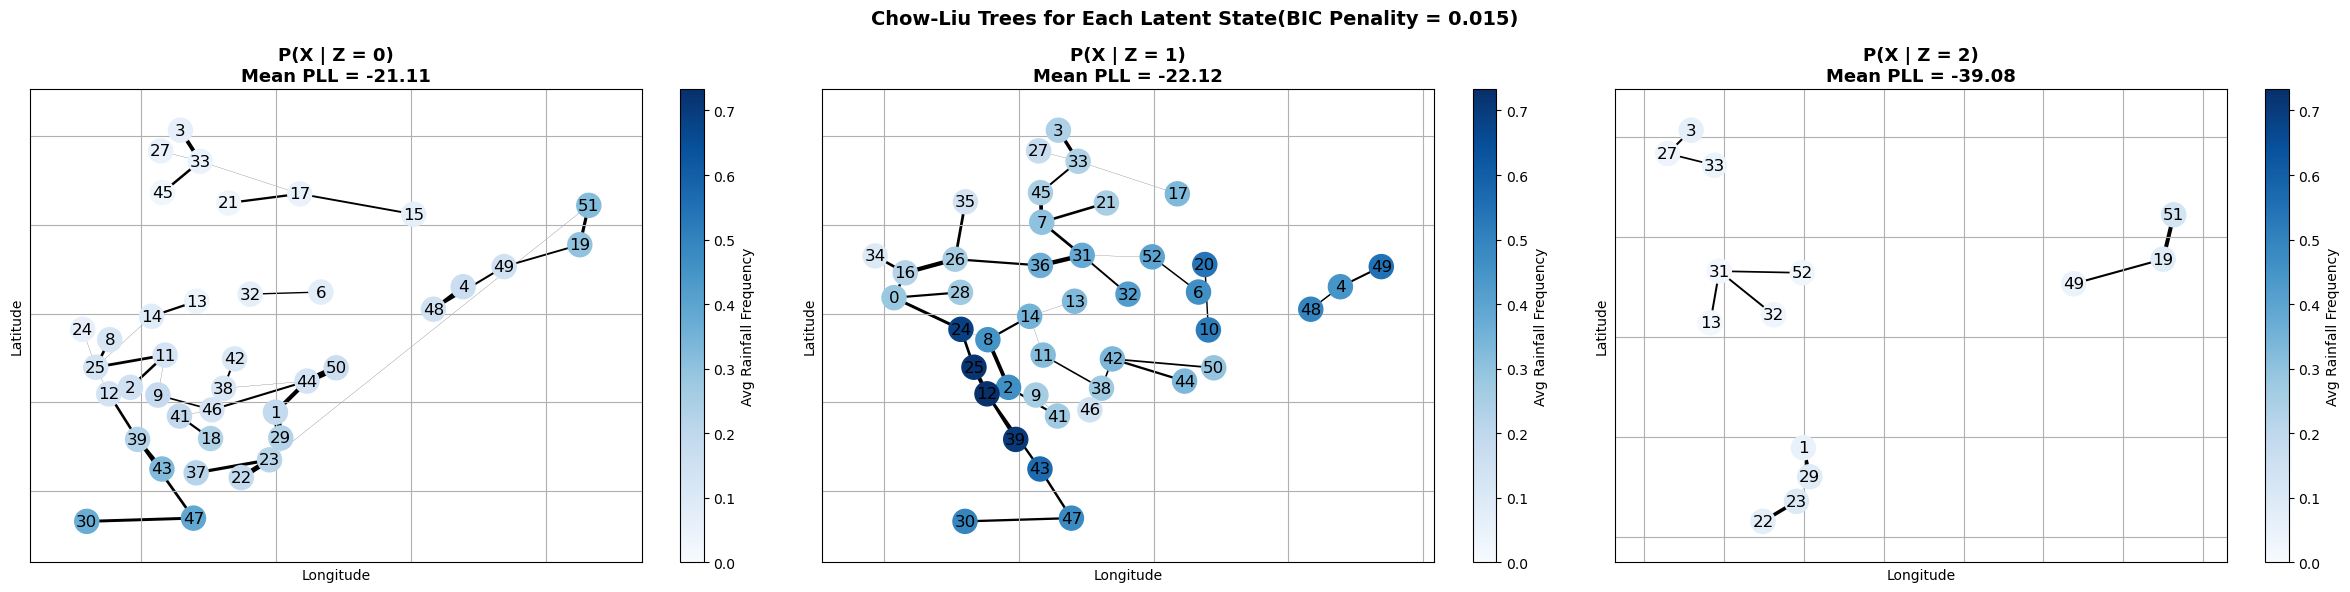

In [8]:
fig, axes = plt.subplots(1, n, figsize=(24, 6))

# Compute all avg_rain and to find global max for normalization (nodes)
avg_rains = []
for k in range(n):
    days_k = np.where(Z_seq == k)[0]
    avg_rain = labels[days_k].mean(axis=0)
    avg_rains.append(avg_rain)
global_max = np.max(avg_rains)

# find global MI range across all states for normalization (edges)
all_mis = []
for k in range(n):
    mi_edges = getattr(hmm_model2.E[k].model, "mutual_info_edges", [])
    all_mis.extend([mi for _, _, mi in mi_edges])
global_min_mi = min(all_mis)
global_max_mi = max(all_mis)

for k in range(n):
    ax = axes[k]
    avg_rain = avg_rains[k]
    pseudo_ll = hmm_model2.E[k].model.pseudolikelihood(labels).mean()

    draw_chowLiu_tree(ising_cl=hmm_model2.E[k].model, lat=lat,lon=lon, rain_vals=avg_rain,ax=ax, 
                        vmin = 0, vmax = global_max,
                        global_min_mi=global_min_mi, global_max_mi=global_max_mi)

    ax.set_title(f"P(X | Z = {k})\nMean PLL = {pseudo_ll:.2f}", fontsize=13, fontweight='bold')

    #color scale to global range for consistency
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=global_max))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Avg Rainfall Frequency")

fig.suptitle("Chow-Liu Trees for Each Latent State(BIC Penality = 0.015)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Adding BIC Penalty to Chow-Liu Trees (penalty = 0.025)

In [9]:
np.random.seed(12)

n =  3
L =  len(labels)

T = np.eye(n) * 0.90 + 0.1
emitters = [emitChowLiu(labels[np.random.choice(L, size=1000, replace=False)], 0.025) for _ in range(n)]
hmm_model3 = HMM(T, emitters )
hmm_model3.T_prior = np.eye(n) * 50000.

for it in range(100):
    ll = hmm_model3.EM(labels)
    if it % 10 == 0:
        print(f"iter {it}: {ll}")
print("\nmean PLL: ", ll / len(labels))

iter 0: -64728.89255545739
iter 10: -60123.229962239726
iter 20: -60264.37222288467
iter 30: -60264.363666515754
iter 40: -60263.722446529086
iter 50: -60262.54757560635
iter 60: -60262.549343208484
iter 70: -60262.5493485183
iter 80: -60262.54934852943
iter 90: -60262.54934852955

mean PLL:  -16.501245714274244


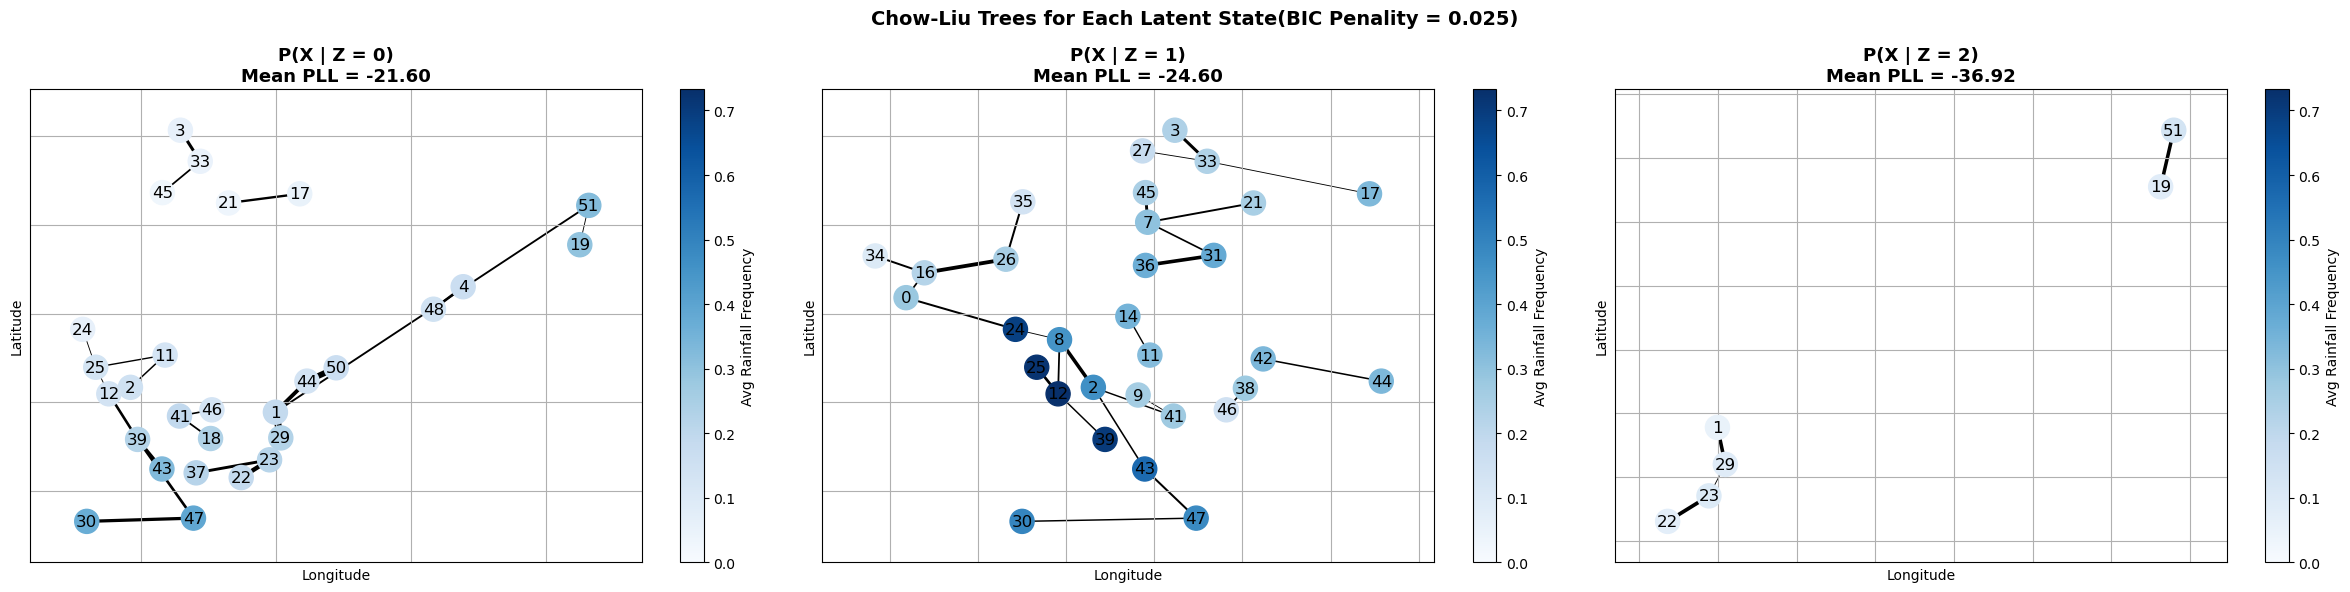

In [10]:
fig, axes = plt.subplots(1, n, figsize=(24, 6))

# Compute all avg_rain and to find global max for normalization (nodes)
avg_rains = []
for k in range(n):
    days_k = np.where(Z_seq == k)[0]
    avg_rain = labels[days_k].mean(axis=0)
    avg_rains.append(avg_rain)
global_max = np.max(avg_rains)

# find global MI range across all states for normalization (edges)
all_mis = []
for k in range(n):
    mi_edges = getattr(hmm_model3.E[k].model, "mutual_info_edges", [])
    all_mis.extend([mi for _, _, mi in mi_edges])
global_min_mi = min(all_mis)
global_max_mi = max(all_mis)

for k in range(n):
    ax = axes[k]
    avg_rain = avg_rains[k]
    pseudo_ll = hmm_model3.E[k].model.pseudolikelihood(labels).mean()

    draw_chowLiu_tree(ising_cl=hmm_model3.E[k].model, lat=lat,lon=lon, rain_vals=avg_rain,ax=ax, 
                        vmin = 0, vmax = global_max,
                        global_min_mi=global_min_mi, global_max_mi=global_max_mi)

    ax.set_title(f"P(X | Z = {k})\nMean PLL = {pseudo_ll:.2f}", fontsize=13, fontweight='bold')

    #color scale to global range for consistency
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=global_max))
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label="Avg Rainfall Frequency")

fig.suptitle("Chow-Liu Trees for Each Latent State(BIC Penality = 0.025)", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# model selection (BIC)

In [16]:
N = len(labels)     # num days
d = labels.shape[1] #num stations

bic_scores = []
for n in range(1,7):
    
    np.random.seed(12)  # i set the seed at every iteration, so that models with different n values are trained on same subset of data
    T = np.eye(n) * 0.90 + 0.1   
    emitters = [emitChowLiu(labels[np.random.choice(N, size=1000, replace=False)]) for _ in range(n)]
    model = HMM(T, emitters)
    model.T_prior = np.eye(n) * 50000.

    for i in range(50):
        ll = model.EM(labels)

    bic = compute_bic(ll, n, d, N)
    bic_scores.append((n, bic))
    print(f"n = {n}, BIC = {bic:.2f}, logL = {ll:.2f}, mean logL = {ll/N:.2f}")

n = 1, BIC = 136643.02, logL = -67890.85, mean logL = -18.59
n = 2, BIC = 123780.22, logL = -61016.49, mean logL = -16.71
n = 3, BIC = 118692.72, logL = -58021.57, mean logL = -15.89
n = 4, BIC = 118951.73, logL = -57691.71, mean logL = -15.80
n = 5, BIC = 119264.53, logL = -57380.53, mean logL = -15.71
n = 6, BIC = 118897.73, logL = -56721.36, mean logL = -15.53


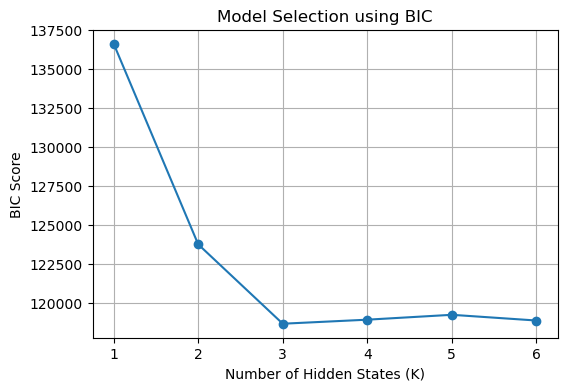

In [17]:
ns   = [pair[0] for pair in bic_scores]   # number of states
bics = [pair[1] for pair in bic_scores]   # BIC scores

plt.figure(figsize=(6, 4))
plt.plot(ns, bics, marker='o')
plt.xlabel("Number of Hidden States (K)")
plt.ylabel("BIC Score")
plt.title("Model Selection using BIC")
plt.grid(True)


# Model Selection (LOOCV)


In [9]:
for n in [2, 3, 4, 5]:

    np.random.seed(12)  # i set the seed at every iteration, so that models with different n values are trained on same subset of data

    tot_ll, pll_per_day= LOOCV(labels, n_states=n)
    
    print(f"n = {n}, Total PLL = {tot_ll:.2f}, PLL/day = {pll_per_day:.4f}\n")

n = 2, Total PLL = -62380.82, PLL/day = -17.0813

n = 3, Total PLL = -61297.25, PLL/day = -16.7846

n = 4, Total PLL = -61016.31, PLL/day = -16.7076

n = 5, Total PLL = -61562.70, PLL/day = -16.8573

